# Activity recognition on the Capture24 dataset

Our aim is to build a baseline machine learning model to recognize
activities from wrist-worn accelerometer measurements.
Our baseline is a random forest classifier trained on the hand-crafted
features `X_feats`.

Setup:

In [1]:
import numpy as np
from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import utils  # contains helper functions for this workshop -- check utils.py

# For reproducibility
np.random.seed(42)

# A useful plotting function
def plot_activity(X, y, pid, time, ipid=3):
    mask = pid == ipid
    return utils.plot_activity(X[:,0][mask], y[mask], time[mask])

 Load dataset and hold out some instances for testing: 

In [2]:
# Load data
# data = np.load('capture24.npz', allow_pickle=True)
data = np.load('/tmp/capture24_small.npz', allow_pickle=True)
print("Data contents:", data.files)
X, y, pid, time = data['X_feats'], data['y'], data['pid'], data['time']

# Hold out some participants for testing the model
test_pids = [2, 3]
test_mask = np.isin(pid, test_pids)
train_mask = ~np.isin(pid, test_pids)
X_train, y_train, pid_train, time_train = X[train_mask], y[train_mask], pid[train_mask], time[train_mask]
X_test, y_test, pid_test, time_test = X[test_mask], y[test_mask], pid[test_mask], time[test_mask]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Data contents: ['X_feats', 'y', 'pid', 'time', 'annotation']
Shape of X_train: (6025, 125)
Shape of X_test: (4991, 125)


 Train a random forest classifier: 

In [3]:
# Argument oob_score=True to be used for HMM smoothing (see below)
classifier = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=2)
classifier.fit(X_train, y_train)

y_test_pred = classifier.predict(X_test)
print("\n--- Random forest performance ---")
print("Cohen kappa score:", utils.cohen_kappa_score(y_test, y_test_pred, pid_test))
print("Accuracy score:", utils.accuracy_score(y_test, y_test_pred, pid_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))


--- Random forest performance ---
Cohen kappa score: 0.7819259833307741
Accuracy score: 0.8719676499705976
Confusion matrix:
 [[1868   54    1    3    2]
 [ 109 2058    0   42   12]
 [  19   85    0   21    3]
 [   1   89    5  157   58]
 [   4   65    1   63  271]]


 Plot activity timeseries for participant #3 

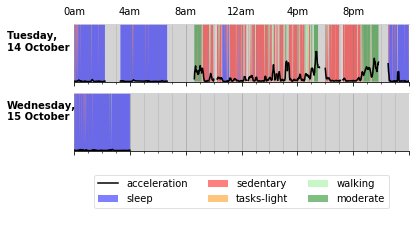

In [4]:
fig, ax = plot_activity(X_test, y_test_pred, pid_test, time_test, ipid=3)
fig.show()

The random forest classifier performs descently well.
However, the model does not account for temporal dependencies since we simply
trained it to classify individual intervals of 30 seconds of activity.
This can be seen in the activity plot where the sleep period is not smooth.
To account for the temporal component, we consider smoothing the predictions
by applying a mode filter, i.e. we pass a window (here of size 3) along the
timeseries and pick the most popular activity within the window.

**Note:** As mentioned before, the provided arrays `X_feats`, `X_raw`, `y`, etc. are so that measurements of a same participant are contiguous and continuous time intervals correspond to continuous rows, however interrupts (time gaps) in the measurements may exist.
Time discontinuities will also of course occur at the edges between participants.
In the following time smoothing approaches we do not account for these interrupts -- the number of these are negligible so we ignore them. You could properly account for them by looking at the `time` and `pid` arrays.

### Time smoothing

#### mode smoothing


--- Random forest performance with mode filtering ---
Cohen kappa score: 0.8047015661254935
Accuracy score: 0.8867897843579495
Confusion matrix:
 [[1905   21    0    2    0]
 [  82 2105    0   31    3]
 [  19   91    0   18    0]
 [   3  111    6  148   42]
 [   3   72    0   56  273]]


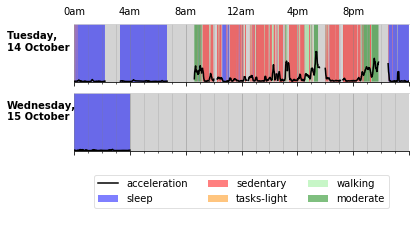

In [6]:
y_test_modefilt = mode(
    np.vstack((y_test_pred[:-2], y_test_pred[1:-1], y_test_pred[2:])),
    axis=0)[0].ravel()
y_test_modefilt = np.concatenate(([y_test_pred[0]], y_test_modefilt, [y_test_pred[-1]]))
print("\n--- Random forest performance with mode filtering ---")
print("Cohen kappa score:", utils.cohen_kappa_score(y_test, y_test_modefilt, pid_test))
print("Accuracy score:", utils.accuracy_score(y_test, y_test_modefilt, pid_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_modefilt))

fig, ax = plot_activity(X_test, y_test_modefilt, pid_test, time_test, ipid=3)
fig.show()

We see that this simple mode smoothing improves both accuracy and kappa
scores, and the activity plot is now smoother.

A more principled approch is to use a Hidden Markov Model (HMM). Here we
assume that the random forest predictions are mere "observations" of the
"hidden ground truth".
HMM requires that we obtain prior, emission and transition matrices. We can
estimate these using the ground truth labels `y_train` together with the
classifier's probabilistic predictions on the training set (`predict_proba` method on `X_train`):

#### Hidden Markov Models


--- Random forest performance with HMM smoothing (in-bag estimate) ---
Cohen kappa score: 0.8306384122887969
Accuracy score: 0.9009233826846208
Confusion matrix:
 [[1915    8    2    3    0]
 [  65 2117    0   34    5]
 [  17   86    0   25    0]
 [   0   89    2  173   46]
 [   0   46    0   62  296]]


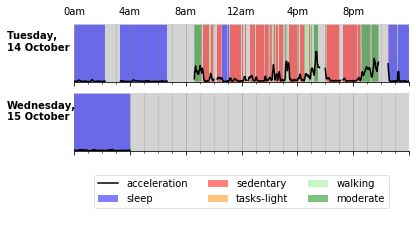

In [8]:
Y_train_pred = classifier.predict_proba(X_train)
prior, emission, transition = utils.train_hmm(Y_train_pred, y_train)
y_test_hmm_in = utils.viterbi(y_test_pred, prior, transition, emission)
print("\n--- Random forest performance with HMM smoothing (in-bag estimate) ---")
print("Cohen kappa score:", utils.cohen_kappa_score(y_test, y_test_hmm_in, pid_test))
print("Accuracy score:", utils.accuracy_score(y_test, y_test_hmm_in, pid_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_hmm_in))

fig, ax = plot_activity(X_test, y_test_hmm_in, pid_test, time_test, ipid=3)
fig.show()

#### Hidden Markov Models (trained using 'out of bag' estimates from Random Forest)

The HMM smoothing further improves the scores, and the activity plot is even smoother.

The random forest classifier can provide out-of-bag estimates on the training set (enabled by passing the `oob_score=True` argument), accessible via the attribute `oob_decision_function_`. These estimated predictions are closer to the actual out-of-sample performance of the model. We can use these to compute again the HMM parameters:


--- Random forest performance with HMM smoothing (out-of-bag estimate) ---
Cohen kappa score: 0.8328136024485233
Accuracy score: 0.9029499117929479
Confusion matrix:
 [[1920    8    0    0    0]
 [  65 2127    0   25    4]
 [  17  103    0    8    0]
 [   0   96    0  153   61]
 [   0   41    0   51  312]]


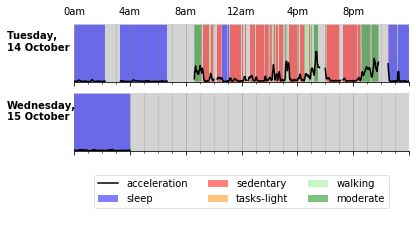

In [9]:
Y_oob = classifier.oob_decision_function_
prior, emission, transition = utils.train_hmm(Y_oob, y_train)
y_test_hmm_out = utils.viterbi(y_test_pred, prior, transition, emission)
print("\n--- Random forest performance with HMM smoothing (out-of-bag estimate) ---")
print("Cohen kappa score:", utils.cohen_kappa_score(y_test, y_test_hmm_out, pid_test))
print("Accuracy score:", utils.accuracy_score(y_test, y_test_hmm_out, pid_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_hmm_out))

fig, ax = plot_activity(X_test, y_test_hmm_in, pid_test, time_test, ipid=3)
fig.show()

## Is a simple logistic regression enough?

*Note this next step will take a few minutes!*


--- Logistic regression performance ---
Cohen kappa score: 0.5088735349379176
Accuracy score: 0.7082858801723946
Confusion matrix:
 [[1755  163    1    0    9]
 [ 702 1468    2   33   16]
 [  22   88    0   15    3]
 [   5  128    2  117   58]
 [   7  118    0   60  219]]


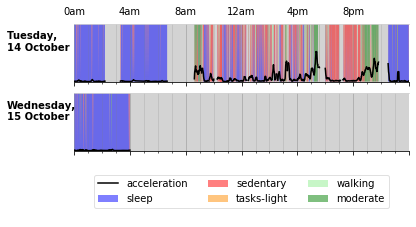

In [10]:
classifier_LR = LogisticRegression(
    random_state=42, solver='saga', multi_class='multinomial', max_iter=10000, n_jobs=2)
classifier_LR.fit(X_train, y_train)
y_test_LR = classifier_LR.predict(X_test)
print("\n--- Logistic regression performance ---")
print("Cohen kappa score:", utils.cohen_kappa_score(y_test, y_test_LR, pid_test))
print("Accuracy score:", utils.accuracy_score(y_test, y_test_LR, pid_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_LR))

fig, ax = plot_activity(X_test, y_test_LR, pid_test, time_test, ipid=3)
fig.show()

Next we apply HMM smoothing on the logistic regression predictions:

In [ ]:
Y_train_LR_pred = classifier_LR.predict_proba(X_train)
prior, emission, transition = utils.train_hmm(Y_train_LR_pred, y_train)
y_test_LR_hmm = utils.viterbi(y_test_LR, prior, transition, emission)
print("\n--- Logistic regression performance with HMM smoothing ---")
print("Cohen kappa score:", utils.cohen_kappa_score(y_test, y_test_LR_hmm, pid_test))
print("Accuracy score:", utils.accuracy_score(y_test, y_test_LR_hmm, pid_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_LR_hmm))

fig, ax = plot_activity(X_test, y_test_LR_hmm, pid_test, time_test, ipid=3)
fig.show()

HMM on top of the logistic regression model substantially improves its
performance. But although the predictions are smooth, the scores are much
lower than in the previous models.

Now that we have repeatedly evaluated on the test set and taken decisions
based on it (we have abused the test set), the reported scores are no longer
an unbiased estimate of the generalization performance. Our test set has
become a "validation set" (link). A true test set will be provided at the end
of this workshop to truly assess the performance of your model.

*To try:*

- Tune hyperparameters of the random forest (`n_estimators`, `max_depth`,
`criterion`, etc.). See [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).
- Tune the hyperparameters of the logistic regression (`penalty`, `C`, `max_iter`, etc.). See [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
- How would you select the best set of hyperparameters for a model?
- Can we improve performance by balancing the dataset?
- Given that the dataset is highly unbalanced, should we focus solely on the accuracy score?